# Model Training

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

import seaborn as sb
import matplotlib.pyplot as plt
from tabulate import tabulate
import joblib

In [2]:
X_train, X_test = pd.read_csv('X_train_preprocessed.csv',index_col=0), pd.read_csv('X_test_preprocessed.csv',index_col=0)

y = pd.read_csv('target.csv',index_col=0)
y_train = y.loc[X_train.index,'Credit_Score']
y_test = y.loc[X_test.index,'Credit_Score']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70000, 41), (70000,), (30000, 41), (30000,))

In [3]:
# Class percentages
# We did a stratified train_test split so y_train will also have the same perecentages 
(y_test.value_counts()/len(y_test)) * 100

Credit_Score
Standard    53.173333
Poor        28.996667
Good        17.830000
Name: count, dtype: float64

- Most of samples belong to the class Standard (53.17%)
- Samples belonging to class Good are only 17.8% and class Poor are 28.9%
- Hence our dataset is imbalanced

 - Since the dataset is imbalanced, F1 Score (macro) will be considered as the main evaluation metric the model
 - F1 Score (macro) will provide the average of F1 Scores that was computed for each classes individually
 - We will also create a classification report to view the individual Precision, Recall and F1 Scores of each Classes

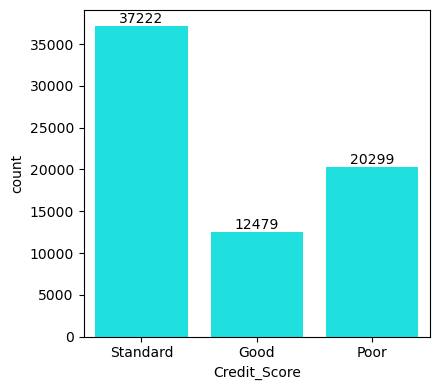

In [4]:
# Count of each classes in training set
plt.figure(figsize=(4.5,4))
ax = sb.countplot(x=y_train,color='cyan')
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

In [5]:
# Encoding the Target classes to numeric
class_mapper = {'Poor': 0, 'Standard': 1, 'Good': 2}
y_train.replace(class_mapper,inplace=True)
y_test.replace(class_mapper,inplace=True)

- Training the data using Logistic Regression

In [6]:
# Logistic Regression Model
lgr = LogisticRegression(max_iter=500,class_weight='balanced').fit(X_train,y_train)
y_pred = lgr.predict(X_test)
y_pred_proba = lgr.predict_proba(X_test)

print(f'- F1-Score: {f1_score(y_test,y_pred,average="macro")}')
print(f'- ROC-AUC: {roc_auc_score(y_test,y_pred_proba,average="macro",multi_class="ovr")}')
print('\nClassification Report:\n',classification_report(y_test,y_pred))

- F1-Score: 0.6489867998403765
- ROC-AUC: 0.8128195439907402

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65      8699
           1       0.81      0.58      0.68     15952
           2       0.49      0.82      0.61      5349

    accuracy                           0.66     30000
   macro avg       0.64      0.70      0.65     30000
weighted avg       0.70      0.66      0.66     30000



- Using other algorithms

In [7]:
# Checking model performance using various algorithms to find the best one
models = [DecisionTreeClassifier(class_weight='balanced'),
          RandomForestClassifier(class_weight='balanced'),
          XGBClassifier(),
          CatBoostClassifier(verbose=0,auto_class_weights='Balanced'),
          KNeighborsClassifier()]

# Dictionary and list for storing models and eval scores respectively
fitted_models = {}
scores = []


for model in models:
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    y_pred_train = model.predict(X_train)
    y_pred_proba_train = model.predict_proba(X_train)

    auc = roc_auc_score(y_test,y_pred_proba,average="macro",multi_class="ovr")
    f1 = f1_score(y_test,y_pred,average="macro")

    print(f'\nModel: {type(model).__name__}')
    print(f'\nPerformance metrics of Training Set:')
    print(f'- ROC-AUC: {roc_auc_score(y_train,y_pred_proba_train,average="macro",multi_class="ovr"):.2f}')
    print(f'- F1-Score: {f1_score(y_train,y_pred_train,average="macro"):.2f}')
    print('-'*60)

    print(f'Performance metrics of Testing Set:')
    print(f'- ROC-AUC: {auc:.2f}')
    print(f'- F1-Score: {f1:.2f}')
    print('-'*60)
    print('Classification Report:\n\n',classification_report(y_test,y_pred))
    print('='*60)
    fitted_models[type(model).__name__] = model
    scores.append(f1)


Model: DecisionTreeClassifier

Performance metrics of Training Set:
- ROC-AUC: 1.00
- F1-Score: 1.00
------------------------------------------------------------
Performance metrics of Testing Set:
- ROC-AUC: 0.76
- F1-Score: 0.68
------------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      8699
           1       0.73      0.74      0.73     15952
           2       0.64      0.63      0.63      5349

    accuracy                           0.70     30000
   macro avg       0.69      0.68      0.68     30000
weighted avg       0.70      0.70      0.70     30000


Model: RandomForestClassifier

Performance metrics of Training Set:
- ROC-AUC: 1.00
- F1-Score: 1.00
------------------------------------------------------------
Performance metrics of Testing Set:
- ROC-AUC: 0.92
- F1-Score: 0.78
------------------------------------------------------------
Classifi

In [8]:
df_results = pd.DataFrame(zip(fitted_models.keys(), scores),
                          columns=['Model','F1-Score']).sort_values(by='F1-Score',ascending=False)
df_results

,Model,F1-Score
1,RandomForestClassifier,0.784609
2,XGBClassifier,0.742693
3,CatBoostClassifier,0.729641
4,KNeighborsClassifier,0.705484
0,DecisionTreeClassifier,0.683633


___

## Hyperparameter Tuning

- In the above models it is clearly seen that our train scores is in most cases much higher than test scores
- So we have a high variance/overfitting problem on our hands
- We will tune the hyperparameters of our two best models to reduce overfitting and getter generalization to unseen data

In [9]:
# Tuning RandomForest model
param_grid = {
    'n_estimators': [75, 100, 105],
    'max_depth': [40, 45, 50],
    'max_features': [0.24, 0.245, 0.25],
    'min_samples_split': [4],
    'min_samples_leaf': [1],
    'class_weight': ['balanced'],
    'bootstrap': [False],
    'ccp_alpha': [1e-5, 0.9e-5]
}

# Using HalvingGridSearchCV for tuning
halving_search_rf = HalvingGridSearchCV(estimator=RandomForestClassifier(),
                                        param_grid=param_grid,
                                        scoring='f1_macro',
                                        cv=5,
                                        return_train_score=True,
                                        verbose=1,
                                        n_jobs=-1)
halving_search_rf.fit(X_train,y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2592
max_resources_: 70000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 2592
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 1
n_candidates: 18
n_resources: 7776
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 6
n_resources: 23328
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 3
n_candidates: 2
n_resources: 69984
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                    param_grid={'bootstrap': [False],
                                'ccp_alpha': [1e-05, 9e-06],
                                'class_weight': ['balanced'],
                                'max_depth': [40, 45, 50],
                                'max_features': [0.24, 0.245, 0.25],
                                'min_samples_leaf': [1],
                                'min_samples_split': [4],
                                'n_estimators': [75, 100, 105]},
                    scoring='f1_macro', verbose=1)

In [10]:
# Assigning the best rf model based on f1_macro
best_estimator_rf = halving_search_rf.best_estimator_

# Best hyperparameters for this model
best_params_rf = halving_search_rf.best_params_

# Making a dataframe containing the details of all the fits
rf_cv_df = pd.DataFrame(halving_search_rf.cv_results_)
rf_cv_df.to_csv('rf_cv_df.csv',index=False)
rf_cv_df

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_ccp_alpha,param_class_weight,param_max_depth,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,2592,3.931652,0.071159,0.054276,0.004841,False,0.00001,balanced,40,...,0.648270,0.007997,72,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0,2592,5.530838,0.641230,0.099306,0.019165,False,0.00001,balanced,40,...,0.652781,0.018191,55,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0,2592,6.272800,0.685143,0.091159,0.033940,False,0.00001,balanced,40,...,0.655251,0.018399,48,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0,2592,3.929910,0.237280,0.057826,0.010237,False,0.00001,balanced,40,...,0.647768,0.006842,74,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0,2592,5.828894,0.169533,0.074883,0.022747,False,0.00001,balanced,40,...,0.656255,0.011632,43,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2,23328,97.237357,2.326807,0.658627,0.224077,False,0.000009,balanced,45,...,0.734555,0.007163,4,1.000000,1.000000,0.999933,1.000000,1.000000,0.999987,0.000027
76,2,23328,75.075092,2.886805,0.573760,0.135987,False,0.000009,balanced,50,...,0.733606,0.004182,6,1.000000,1.000000,0.999933,1.000000,1.000000,0.999987,0.000027
77,2,23328,52.699874,8.528384,0.334353,0.015932,False,0.00001,balanced,45,...,0.734024,0.005066,5,0.999933,1.000000,0.999867,1.000000,1.000000,0.999960,0.000053
78,3,69984,208.924788,11.280844,1.130407,0.144392,False,0.000009,balanced,45,...,0.791829,0.003283,1,0.999758,0.999755,0.999714,0.999812,0.999755,0.999759,0.000031


In [11]:
# Saiving the tuned RandomForestClassifier model
joblib.dump(halving_search_rf,'halving_search_rf.joblib')

['halving_search_rf.joblib']

In [12]:
# Tuning the XGBoost model
param_grid = {
    'n_estimators': [250, 350, 450],
    'gamma': [0.01, 0.02],
    'learning_rate': [0.15, 0.14],
    'max_depth': [10, 25, 35],
    'colsample_bytree': [0.65, 0.6, 0.7],
    'reg_alpha': [1, 1.1],
    'reg_lambda': [0.5],
    'objective': ['multi:softprob'],
    'verbosity': [0]
}

# Using HalvingGridSearchCV for tuning
halving_search_xg = HalvingGridSearchCV(estimator=XGBClassifier(),
                                        param_grid=param_grid,
                                        cv=5,
                                        n_jobs=-1,
                                        return_train_score=True,
                                        scoring='f1_macro',
                                        verbose=1)
halving_search_xg.fit(X_train,y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 864
max_resources_: 70000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 216
n_resources: 864
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


----------
iter: 1
n_candidates: 72
n_resources: 2592
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------
iter: 2
n_candidates: 24
n_resources: 7776
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 8
n_resources: 23328
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 69984
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=Non...
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...),
                    n_jobs=-1,
                    param_grid={'colsample_bytree': [0.65, 0.6, 0.7],
                                'gamma': [0.01, 0.02],
                                'learning_rate': [0.15, 0.14],
                                'max_depth': [10, 25, 35],
                                'n_estimators': [250, 350, 450],
                                'objective': ['multi:softprob'],
                                'reg_alpha': [1, 1.1], 'reg_lambda': [0.5],
                                'verbosity': [0]},
                    scoring='f1_macro', verbose=1)

In [13]:
# Assigning best XGBoost model based on f1_macro
best_estimator_xg = halving_search_xg.best_estimator_

# Best hyperparameters for this model
best_params_xg = halving_search_xg.best_params_

# Making a dataframe containing the details of all the fits
xg_cv_df = pd.DataFrame(halving_search_xg.cv_results_)
xg_cv_df.to_csv('xg_cv_df.csv',index=False)
xg_cv_df

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,864,2.456080,0.042387,0.040623,0.007655,0.65,0.01,0.15,10,...,0.583763,0.036770,291,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0,864,2.340817,0.071670,0.031249,0.000001,0.65,0.01,0.15,10,...,0.588229,0.043784,240,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0,864,2.521700,0.037757,0.037498,0.007654,0.65,0.01,0.15,10,...,0.583763,0.036770,291,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0,864,2.499828,0.039526,0.034374,0.006249,0.65,0.01,0.15,10,...,0.588229,0.043784,240,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0,864,2.844844,0.057880,0.034374,0.006251,0.65,0.01,0.15,10,...,0.583763,0.036770,291,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,3,23328,129.009560,22.519311,1.503207,0.554651,0.65,0.02,0.14,25,...,0.720109,0.007229,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
319,3,23328,137.115896,7.831634,1.542034,0.306290,0.65,0.02,0.14,25,...,0.720109,0.007229,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
320,4,69984,423.154846,28.036105,6.519185,2.071453,0.65,0.02,0.14,25,...,0.784260,0.002687,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0
321,4,69984,450.020796,27.826221,8.767332,2.271907,0.7,0.02,0.15,35,...,0.783879,0.002806,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [14]:
# Saving the tuned XGBClassifier model
joblib.dump(halving_search_xg,'halving_search_xg.joblib')

['halving_search_xg.joblib']

In [15]:
# Predictions for X_test with the tuned models
y_pred_rf = best_estimator_rf.predict(X_test)
y_pred_proba_rf = best_estimator_rf.predict_proba(X_test)

y_pred_xg = best_estimator_xg.predict(X_test)
y_pred_proba_xg = best_estimator_xg.predict_proba(X_test)

# F1_Score (macro) of tuned RandomForestClassifier model
f1_rf = f1_score(y_test,y_pred_rf,average='macro')

# F1_Score (macro) of tuned XGBClassifier model
f1_xg = f1_score(y_test,y_pred_xg,average='macro')

In [16]:
# Calculating The ROC-AUC and Classification Report for the Testing set with the tuned models
roc_auc_rf = roc_auc_score(y_test,y_pred_proba_rf,average=None,multi_class="ovr")
roc_auc_xg = roc_auc_score(y_test,y_pred_proba_xg,average=None,multi_class="ovr")
roc_auc_rf_dict = [{f'Class {i} ({list(class_mapper.keys())[i]})': score for i, score in enumerate(roc_auc_rf)}]
roc_auc_xg_dict = [{f'Class {i} ({list(class_mapper.keys())[i]})': score for i, score in enumerate(roc_auc_xg)}]

# Classifiation reports of the test set
cr_rf = classification_report(y_test,y_pred_rf)
cr_xg = classification_report(y_test,y_pred_xg)

# Getting the confusion matrices of the tuned models
cm_rf = confusion_matrix(y_test,y_pred_rf,labels=best_estimator_rf.classes_)
cm_xg = confusion_matrix(y_test,y_pred_xg,labels=best_estimator_xg.classes_)

Model: RandomForestClassifier

- F1-Score: 0.802


- ROC-AUC Score :
+------------------+----------------------+------------------+
|   Class 0 (Poor) |   Class 1 (Standard) |   Class 2 (Good) |
|------------------+----------------------+------------------|
|         0.940871 |             0.878646 |         0.958039 |
+------------------+----------------------+------------------+
--------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      8699
           1       0.84      0.80      0.82     15952
           2       0.77      0.78      0.77      5349

    accuracy                           0.81     30000
   macro avg       0.80      0.81      0.80     30000
weighted avg       0.81      0.81      0.81     30000



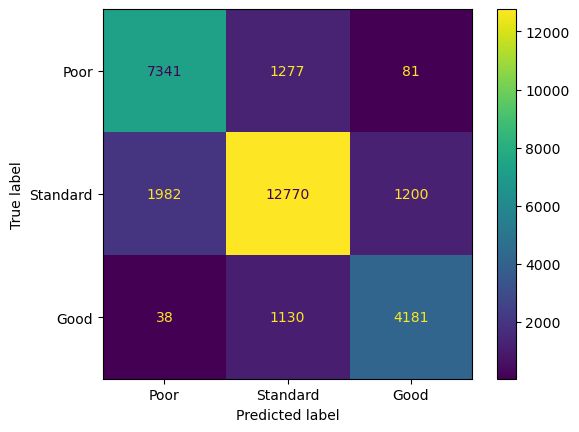

In [17]:
# Results for RandomForestClassifier
print('Model: RandomForestClassifier')
print(f'\n- F1-Score: {f1_rf:.3f}')
print(f"- ROC-AUC Score :\n{tabulate(roc_auc_rf_dict, headers='keys', tablefmt='psql')}")
print('-'*62)
print('Classification Report:\n',cr_rf)
print('='*62)
cm_rf_disp = ConfusionMatrixDisplay(cm_rf,display_labels=['Poor', 'Standard', 'Good'])
cm_rf_disp.plot();

Model: XGBoostClassifier

- F1-Score: 0.799
- ROC-AUC Score :
+------------------+----------------------+------------------+
|   Class 0 (Poor) |   Class 1 (Standard) |   Class 2 (Good) |
|------------------+----------------------+------------------|
|         0.941182 |             0.880763 |          0.95594 |
+------------------+----------------------+------------------+
------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81      8699
           1       0.83      0.82      0.82     15952
           2       0.77      0.76      0.77      5349

    accuracy                           0.81     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.81      0.81      0.81     30000



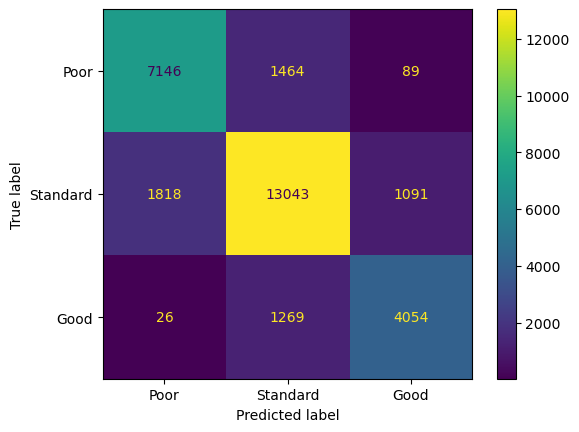

In [18]:
# Results for XGBoostClassifier
print('Model: XGBoostClassifier')
print(f'\n- F1-Score: {f1_xg:.3f}')
print(f"- ROC-AUC Score :\n{tabulate(roc_auc_xg_dict, headers='keys', tablefmt='psql')}")
print('-'*60)
print('Classification Report:\n',cr_xg)
print('='*60)
cm_xg_disp = ConfusionMatrixDisplay(cm_xg,display_labels=['Poor', 'Standard', 'Good'])
cm_xg_disp.plot();

- From the results we can clearly see that we have succefully improved the Test scores (F1-Scores) from what it was initially using Hyperparameter Tuning
- We will now train the dataset again using the VotingClassifier Algorithm and see if the eval scores can be improved further

- The VotingClassifier is a meta-estimator that combines the predictions from multiple base estimators for final classification
- When a dataset is trained using multiple algorithms, it can happen that these models may best capture certain parts of the data better than the other
or they may have different strengths and weaknesses.
- Combining these models using the VotingClassifier may improve the overall classification power of the final model

In [19]:
# Our VotingClassifier will be trained using RandomForestClassifier and XGBClassifier as the base estimators
# These base estimators will be fitted with best parameter obtained from tuning them
voting_clf = VotingClassifier(estimators=[('rf',RandomForestClassifier(**best_params_rf)),
                                          ('xg',XGBClassifier(**best_params_xg))],
                                          voting='soft',
                                          weights=[2,1])
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     ccp_alpha=9e-06,
                                                     class_weight='balanced',
                                                     max_depth=45,
                                                     max_features=0.245,
                                                     min_samples_split=4)),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.65, device=None,
                                            early_stopping_rounds=None,
                                            enable_categ...
                                            interaction_constraints=None,
                                            learning_rate=0.14, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=25,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=350, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft', weights=[2, 1])

In [20]:
# Saving the VotingClassifier model
joblib.dump(voting_clf,'voting_clf.joblib')

['voting_clf.joblib']

In [21]:
# Predictions for X_test with the VotingClassifier
y_pred_vc = voting_clf.predict(X_test)
y_pred_proba_vc = voting_clf.predict_proba(X_test)

# F1_Score (macro) of VotingClassifier model
f1_vc = f1_score(y_test,y_pred_vc,average='macro')

# Calculating The ROC-AUC and Classification Report for the Testing set with VotingClassifier
roc_auc_vc = roc_auc_score(y_test,y_pred_proba_vc,average=None,multi_class="ovr")
roc_auc_vc_dict = [{f'Class {i} ({list(class_mapper.keys())[i]})': score for i, score in enumerate(roc_auc_vc)}]


# Classifiation reports of the test set
cr_vc = classification_report(y_test,y_pred_vc)

# Getting the confusion matrices of VotingClassifier
cm_vc = confusion_matrix(y_test,y_pred_vc,labels=voting_clf.classes_)

Ensemble Model: VotingClassifier

- F1-Score: 0.806
- ROC-AUC Score :
+------------------+----------------------+------------------+
|   Class 0 (Poor) |   Class 1 (Standard) |   Class 2 (Good) |
|------------------+----------------------+------------------|
|          0.94277 |             0.882521 |            0.959 |
+------------------+----------------------+------------------+
------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      8699
           1       0.84      0.81      0.82     15952
           2       0.78      0.78      0.78      5349

    accuracy                           0.81     30000
   macro avg       0.80      0.81      0.81     30000
weighted avg       0.81      0.81      0.81     30000



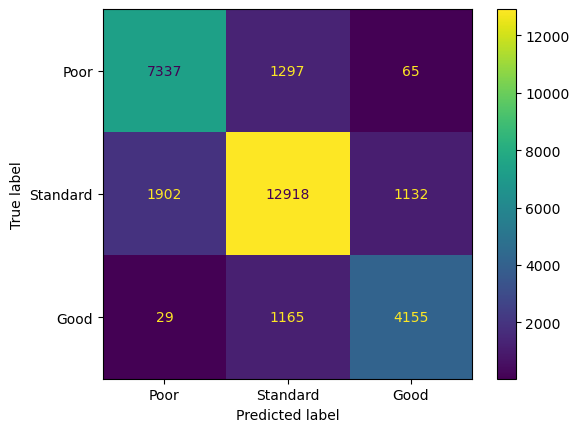

In [22]:
# Results for VotingClassifier
print('Ensemble Model: VotingClassifier')
print(f'\n- F1-Score: {f1_vc:.3f}')
print(f"- ROC-AUC Score :\n{tabulate(roc_auc_vc_dict, headers='keys', tablefmt='psql')}")
print('-'*60)
print('Classification Report:\n',cr_vc)
print('='*60)
cm_vc_disp = ConfusionMatrixDisplay(cm_vc,display_labels=['Poor', 'Standard', 'Good'])
cm_vc_disp.plot();

In [23]:
# Checking if the VotingClassifier actually made any improvements in the test score from the two individual base models
f1_vc > f1_rf > f1_xg

True

- Model further improved with VotingClassifier 